In [2]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [3]:
#We checked inflow data to make sure it matches the outflow data. Our checks showed that the two mirrored each other so we will only use the outflow dataset moving forward but use inflow data for labels that are missing in outflow data
inf_1920 = pd.read_csv("../4. IRS Statistics of Income Tax Migration Data/Final Data/countyinflow1920.csv")
inf_2021 = pd.read_csv("../4. IRS Statistics of Income Tax Migration Data/Final Data/countyinflow2021.csv")
inf_1920['year1'] = '2019'
inf_1920['year2'] = '2020'
inf_2021['year1'] = '2020'
inf_2021['year2'] = '2021'

#agi (adjusted gross income in year 2)
inflow = pd.concat([inf_1920, inf_2021], ignore_index=True)
inflow = inflow[~inflow['y1_countyname'].str.contains('Count Total|Foreign|Total Migration|Other flows|Non-migrants', case=False, na=False)]
#inflow agi is agi of origin county
inflow.rename(columns={'agi': 'agi_orig'}, inplace=True)
# Drop 'n1' column from 'inflow' DataFrame - we'll only look at # of individuals moving
inflow.drop(columns=['n1'], inplace=True)
inflow.rename(columns={'n2': 'n2_inflows'}, inplace=True)
#inflow = inflow[(inflow['y1_state'] == 'NY') | (inflow['y2_statefips'] == 36)]


In [4]:
#Read CSVs
outf_1920 = pd.read_csv("../4. IRS Statistics of Income Tax Migration Data/Final Data/countyoutflow1920.csv")
outf_2021 = pd.read_csv("../4. IRS Statistics of Income Tax Migration Data/Final Data/countyoutflow2021.csv")
#Add year columns before merging
outf_1920['year1'] = '2019'
outf_1920['year2'] = '2020'
outf_2021['year1'] = '2020'
outf_2021['year2'] = '2021'
# Concatenate the two years of data
outflow = pd.concat([outf_1920, outf_2021], ignore_index=True)


In [5]:
#We clean up the dataset by removing the sums, other flows, non-migrant reports and also the foreign travel (which is small but clutters the rows)
# The inflow file shows migration flows into the destination state and county in year one from the origin state and county in year two. 
outflow = outflow[~outflow['y2_countyname'].str.contains('Count Total|Foreign|Total Migration|Other flows|Non-migrants', case=False, na=False)]

# Drop 'n1' column from 'outflow' DataFrame - we'll only look at # of individuals moving
outflow.drop(columns=['n1'], inplace=True)

# Rename 'agi' column in 'outflow' DataFrame to 'agi_year2' and 'n2' is number of individuals in the year2 tax return
outflow.rename(columns={'agi': 'agi_year2'}, inplace=True)
outflow.rename(columns={'n2': 'n_ind_year2'}, inplace=True)

In [6]:
#We only want to see people who moved into NY state from any other place or people who left NY state to go any other place in the US (NY FIPS Code is 36). So we get flows into and out of NY 
#flows = outflow[(outflow['y2_state'] == 'NY') | (outflow['y1_statefips'] == 36)]

In [7]:
flows = outflow

In [8]:
#Add names of origin county and origin state (not in outflow data)
inflow['y1_key'] = inflow['y1_statefips'].astype(str) + '-' + inflow['y1_countyfips'].astype(str)
flows['y1_key'] = flows['y1_statefips'].astype(str) + '-' + flows['y1_countyfips'].astype(str)

crosswalk_county = inflow[['y1_key', 'y1_countyname']].drop_duplicates()
crosswalk_county_unique = pd.Series(crosswalk_county['y1_countyname'].values, index=crosswalk_county['y1_key']).to_dict()

unique_states = inflow.drop_duplicates(subset='y1_statefips')[['y1_statefips','y1_state']]
crosswalk_state = pd.Series(unique_states['y1_state'].values, index=unique_states['y1_statefips']).drop_duplicates()

# Insert 'y1_countyname' at the first column position (index 0) directly
flows.insert(0, 'y1_countyname', flows['y1_key'].map(crosswalk_county_unique))
flows.insert(1, 'y1_state', flows['y1_statefips'].map(crosswalk_state))

In [9]:
#Rename columns to make interpretation more intuitive
flows.rename(
    columns={
        'y1_countyname': 'from_county',
        'y1_state': 'from_state',
        'y1_statefips': 'from_statefips',
        'y1_countyfips': 'from_countyfips',
        'y2_countyname': 'to_county',
        'y2_state': 'to_state',
        'y2_statefips': 'to_statefips',
        'y2_countyfips': 'to_countyfips'
    },
    inplace=True
)

In [10]:
#Make sure there are no missings!
missing_values = flows.isnull().sum()
print(missing_values)


from_county        0
from_state         0
from_statefips     0
from_countyfips    0
to_statefips       0
to_countyfips      0
to_state           0
to_county          0
n_ind_year2        0
agi_year2          0
year1              0
year2              0
y1_key             0
dtype: int64


In [11]:
#clean agi var and remove any value <= 0 (there are only a couple of these issues)
flows = flows[flows['agi_year2'] > 0]


In [12]:
flows

,from_county,from_state,from_statefips,from_countyfips,to_statefips,to_countyfips,to_state,to_county,n_ind_year2,agi_year2,year1,year2,y1_key
6,Autauga County,AL,1,1,1,51,AL,Elmore County,1047,25245,2019,2020,1-1
7,Autauga County,AL,1,1,1,101,AL,Montgomery County,553,11867,2019,2020,1-1
8,Autauga County,AL,1,1,1,21,AL,Chilton County,206,3482,2019,2020,1-1
9,Autauga County,AL,1,1,1,73,AL,Jefferson County,87,2819,2019,2020,1-1
10,Autauga County,AL,1,1,1,117,AL,Shelby County,80,2205,2019,2020,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176790,Teton County,WY,56,39,16,19,ID,Bonneville County,38,1880,2020,2021,56-39
176791,Teton County,WY,56,39,56,13,WY,Fremont County,32,619,2020,2021,56-39
176804,Uinta County,WY,56,41,56,37,WY,Sweetwater County,95,2575,2020,2021,56-41
176805,Uinta County,WY,56,41,49,35,UT,Salt Lake County,63,1588,2020,2021,56-41


In [13]:
inflows = flows.groupby(['to_county','to_state', 'to_countyfips','to_statefips', 'year2']).agg({'n_ind_year2': 'sum','agi_year2': 'mean'}).reset_index()
inflows.rename(columns={'to_county': 'county', 'to_state': 'state','to_countyfips': 'county_fips', 'to_statefips': 'state_fips','n_ind_year2': 'n_inflows', 'agi_year2': 'agi_incomers', 'year2': 'year'}, inplace=True)

outflows = flows.groupby(['from_county','from_state','from_countyfips','from_statefips', 'year2']).agg({'n_ind_year2': 'sum','agi_year2': 'mean'}).reset_index()
outflows.rename(columns={'from_county': 'county', 'from_state': 'state','from_countyfips': 'county_fips', 'from_statefips': 'state_fips', 'n_ind_year2': 'n_outflows','agi_year2': 'agi_leavers', 'year2': 'year'}, inplace=True)


In [14]:
outflows

,county,state,county_fips,state_fips,year,n_outflows,agi_leavers
0,Abbeville County,SC,1,45,2020,633,4101.666667
1,Abbeville County,SC,1,45,2021,573,3797.333333
2,Acadia Parish,LA,1,22,2020,2015,4771.750000
3,Acadia Parish,LA,1,22,2021,2011,4066.000000
4,Accomack County,VA,1,51,2020,519,1959.000000
...,...,...,...,...,...,...,...
5651,Yuma County,CO,125,8,2020,48,887.000000
5652,Zapata County,TX,505,48,2020,90,1779.000000
5653,Zapata County,TX,505,48,2021,122,1191.500000
5654,Zavala County,TX,507,48,2020,184,1222.666667


In [103]:
net_migration = pd.merge(inflows, outflows, on=['county', 'county_fips','state_fips','state', 'year'], how='outer')

net_migration['n_inflows'] = net_migration['n_inflows'].fillna(0)
net_migration['n_outflows'] = net_migration['n_outflows'].fillna(0)

net_migration['net_flows'] = net_migration['n_inflows'] - net_migration['n_outflows']


In [104]:
#turn into string and add leading zeroes
net_migration['county_fips'] = net_migration['county_fips'].apply(str).apply(lambda x: x.zfill(3))
net_migration['state_fips'] = net_migration['state_fips'].apply(str).apply(lambda x: x.zfill(2))

net_migration['fips_id'] = net_migration['state_fips'].apply(str) + net_migration['county_fips'] 

net_migration['fips_id'] = net_migration['fips_id'] .astype(str)
net_migration['county_fips'] = net_migration['county_fips'] .astype(str)
net_migration['state_fips'] = net_migration['state_fips'] .astype(str)


In [87]:
net_migration

,county,state,county_fips,state_fips,year,n_inflows,agi_incomers,log_agi_incomers,n_outflows,agi_leavers,log_agi_leavers,net_flows,fips_id
0,Abbeville County,SC,001,45,2020,669.0,3085.000,8.034307,633.0,4101.666667,8.319149,36.0,45001
1,Abbeville County,SC,001,45,2021,738.0,3903.000,8.269501,573.0,3797.333333,8.242054,165.0,45001
2,Acadia Parish,LA,001,22,2020,2137.0,4760.875,8.468187,2015.0,4771.750000,8.470468,122.0,22001
3,Acadia Parish,LA,001,22,2021,2019.0,3700.000,8.216088,2011.0,4066.000000,8.310415,8.0,22001
4,Accomack County,VA,001,51,2020,399.0,2252.750,7.719907,519.0,1959.000000,7.580189,-120.0,51001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,Weston County,WY,045,56,2020,0.0,NaN,NaN,53.0,1830.000000,7.512071,-53.0,56045
5737,Wilcox County,GA,315,13,2021,0.0,NaN,NaN,47.0,678.000000,6.519147,-47.0,13315
5738,Wilkinson County,MS,157,28,2021,0.0,NaN,NaN,85.0,1641.000000,7.403061,-85.0,28157
5739,Wolfe County,KY,237,21,2021,0.0,NaN,NaN,55.0,911.000000,6.814543,-55.0,21237


In [106]:
net_migration.to_csv("../7. Cleaned Datasets/IRS_netmigration.csv")

,county,state,county_fips,state_fips,year,n_inflows,agi_incomers,log_agi_incomers,n_outflows,agi_leavers,log_agi_leavers,net_flows,fips_id
203,Autauga County,AL,001,01,2020,2516.0,8504.857143,9.048393,2166.0,6265.125000,8.742754,350.0,01001
204,Autauga County,AL,001,01,2021,2477.0,5963.900000,8.693480,2285.0,5065.636364,8.530235,192.0,01001
216,Baldwin County,AL,003,01,2020,7263.0,5919.634615,8.686030,4123.0,4335.535714,8.374600,3140.0,01003
217,Baldwin County,AL,003,01,2021,7669.0,5663.542373,8.641805,4120.0,4675.937500,8.450185,3549.0,01003
236,Barbour County,AL,005,01,2020,294.0,1022.500000,6.930006,408.0,1036.857143,6.943949,-114.0,01005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,Wilcox County,AL,131,01,2021,67.0,1000.000000,6.907755,59.0,937.000000,6.842683,8.0,01131
5516,Winston County,AL,133,01,2020,811.0,2389.000000,7.778630,709.0,2243.166667,7.715644,102.0,01133
5517,Winston County,AL,133,01,2021,669.0,2756.000000,7.921536,560.0,2390.000000,7.779049,109.0,01133
5639,Choctaw County,AL,023,01,2020,0.0,NaN,NaN,40.0,1015.000000,6.922644,-40.0,01023


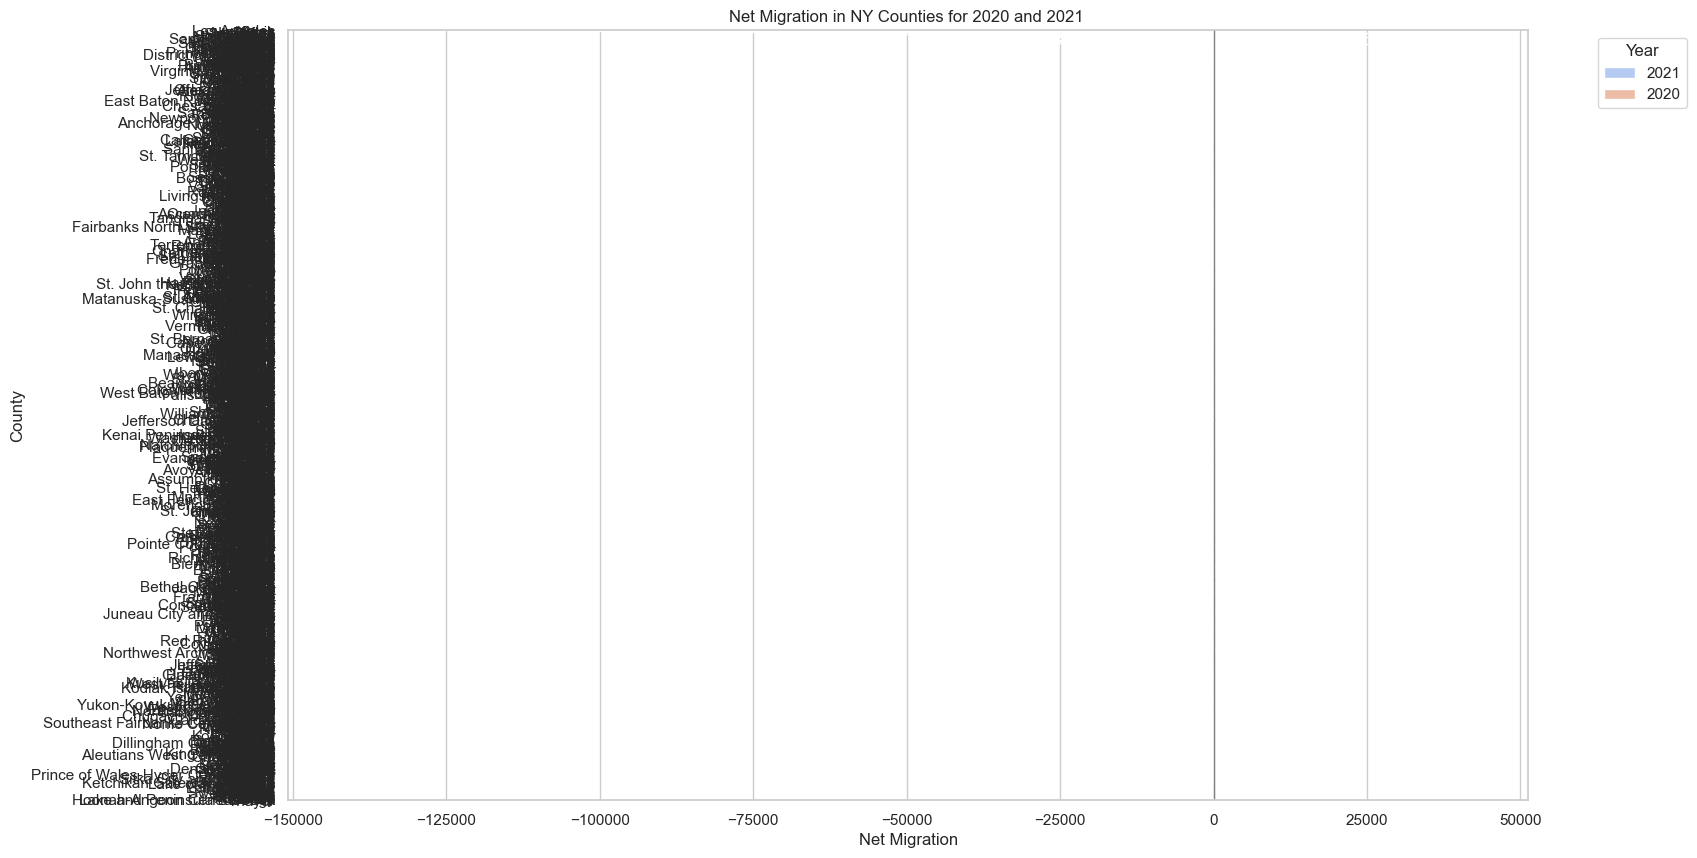

In [90]:
#NEED TO GET POPULATION BY COUNTY SO I CAN DO MIGRATION SHARES!!
#PLOT NET MIGRATION BY COUNTY IN NEW YORK
sns.set_theme(style="whitegrid")

# Ensure 'year' is of type string for proper categorical hue representation
net_migration['year'] = net_migration['year'].astype(str)

# Filter the DataFrame for the years 2020 and 2021 only
net_migration_filtered = net_migration
net_migration_filtered['county'] = net_migration['county'].str.replace(' County', '', regex=False)

# Sort the counties by 2021 outmigration
outflows_2021 = net_migration_filtered[(net_migration_filtered['year'] == '2021')].set_index('county')['n_outflows']
net_migration_filtered = net_migration_filtered.join(outflows_2021, on='county', rsuffix='_2021_outflow')

# Now sort by the outflow of 2021 and then drop the helper column
net_migration_filtered.sort_values(by='n_outflows_2021_outflow', ascending=False, inplace=True)
net_migration_filtered.drop(columns=['n_outflows_2021_outflow'], inplace=True)

# Create a bar plot with hue for different years
plt.figure(figsize=(16, 10))
barplot = sns.barplot(
    x='net_flows',
    y='county',
    hue='year',
    data=net_migration_filtered,
    palette='coolwarm',
    errorbar=None
)

# Add a line at zero for net migration reference
plt.axvline(0, color='grey', linewidth=1)

# Move the legend to the outside of the plot, on the right
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve the aesthetics
plt.xlabel('Net Migration') 
plt.ylabel('County') 
plt.title('Net Migration in NY Counties for 2020 and 2021 ') 

# Show the plot
plt.show()


In [91]:
inflows['log_agi_incomers'] = np.log(inflows['agi_incomers'])
outflows['log_agi_leavers'] = np.log(outflows['agi_leavers'])


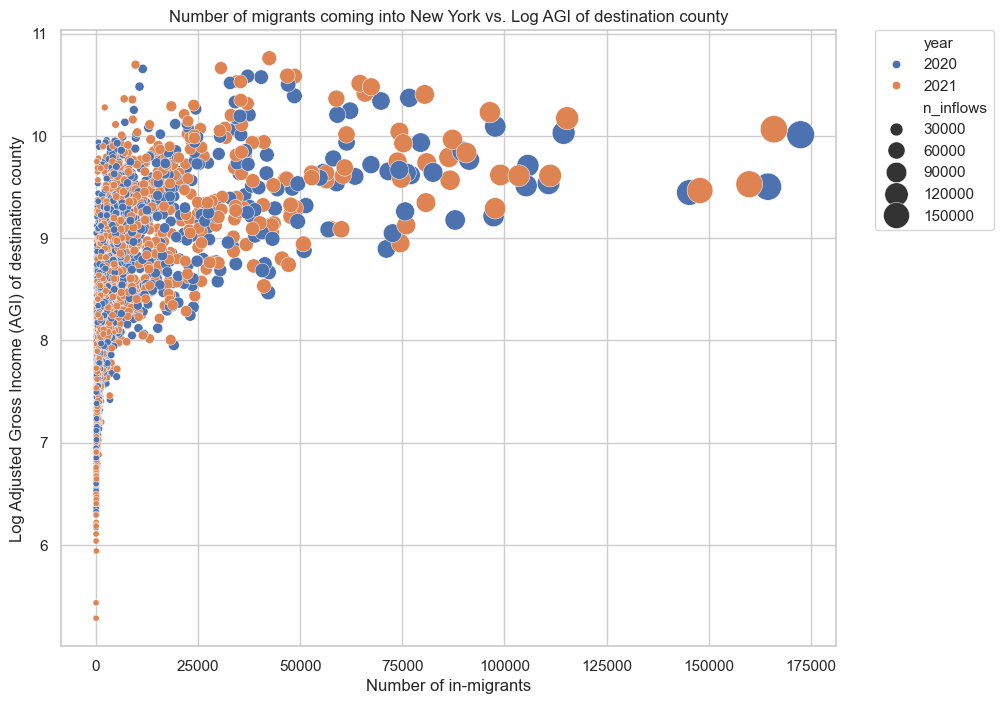

In [92]:
#Migration into the state by county and the AGI of that county 
plt.figure(figsize=(10, 8))
sns.scatterplot(data=inflows, x='n_inflows', y='log_agi_incomers', hue='year',size='n_inflows', sizes=(20, 400))
plt.title('Number of migrants coming into New York vs. Log AGI of destination county')
plt.ylabel('Log Adjusted Gross Income (AGI) of destination county')
plt.xlabel('Number of in-migrants')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()




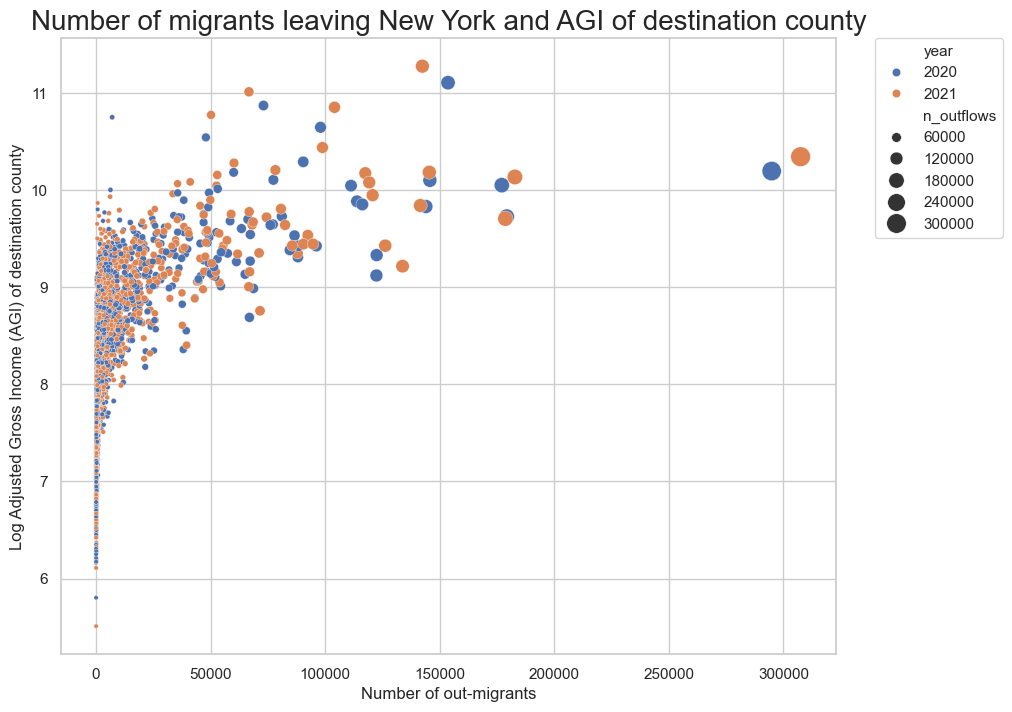

In [93]:
#Migration out of the state by county and the AGI of that county 
plt.figure(figsize=(10, 8))
sns.scatterplot(data=outflows, x='n_outflows', y='log_agi_leavers', hue='year',size='n_outflows', sizes=(10, 200))
plt.title('Number of migrants leaving New York and AGI of destination county', fontsize=20)
plt.ylabel('Log Adjusted Gross Income (AGI) of destination county')
plt.xlabel('Number of out-migrants')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()


The above two plots seem to reinforce that having higher income is associated with more mobility. We see a higher level of migration among destination counties with higher average AGI. 

In [94]:
net_migration

,county,state,county_fips,state_fips,year,n_inflows,agi_incomers,log_agi_incomers,n_outflows,agi_leavers,log_agi_leavers,net_flows,fips_id
0,Abbeville,SC,001,45,2020,669.0,3085.000,8.034307,633.0,4101.666667,8.319149,36.0,45001
1,Abbeville,SC,001,45,2021,738.0,3903.000,8.269501,573.0,3797.333333,8.242054,165.0,45001
2,Acadia Parish,LA,001,22,2020,2137.0,4760.875,8.468187,2015.0,4771.750000,8.470468,122.0,22001
3,Acadia Parish,LA,001,22,2021,2019.0,3700.000,8.216088,2011.0,4066.000000,8.310415,8.0,22001
4,Accomack,VA,001,51,2020,399.0,2252.750,7.719907,519.0,1959.000000,7.580189,-120.0,51001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,Weston,WY,045,56,2020,0.0,NaN,NaN,53.0,1830.000000,7.512071,-53.0,56045
5737,Wilcox,GA,315,13,2021,0.0,NaN,NaN,47.0,678.000000,6.519147,-47.0,13315
5738,Wilkinson,MS,157,28,2021,0.0,NaN,NaN,85.0,1641.000000,7.403061,-85.0,28157
5739,Wolfe,KY,237,21,2021,0.0,NaN,NaN,55.0,911.000000,6.814543,-55.0,21237


In [131]:
acs_dta = pd.read_csv("../7. Cleaned Datasets/analysis_filtered_ACS.csv", dtype={'FIPS_ID': str})
net_migration = pd.read_csv("../7. Cleaned Datasets/IRS_netmigration.csv", dtype={'fips_id': str, 'county_fips': str,  'state_fips': str})

df = pd.merge(net_migration, acs_dta, how='left', left_on='fips_id', right_on='FIPS_ID')



In [136]:
df[df['state']=='AL']

,Unnamed: 0,county,state,county_fips,state_fips,year_x,n_inflows,agi_incomers,log_agi_incomers,n_outflows,...,total_population_hispanic,total_population_hispanic_any_race,total_population_hispanic_mex,total_population_hispanic_puerto_rico,total_population_hispanic_cuban,total_population_hispanic_other,total_housing_units,total_voting_age_pop,total_voting_age_pop_male,total_voting_age_pop_female
327,203,Autauga County,AL,001,01,2020,2516.0,8504.857143,9.048393,2166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,204,Autauga County,AL,001,01,2021,2477.0,5963.900000,8.693480,2285.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,216,Baldwin County,AL,003,01,2020,7263.0,5919.634615,8.686030,4123.0,...,223234.0,10534.0,NaN,NaN,NaN,NaN,119425.0,171344.0,80874.0,90470.0
341,216,Baldwin County,AL,003,01,2020,7263.0,5919.634615,8.686030,4123.0,...,239294.0,11586.0,7487.0,1103.0,380.0,2616.0,128533.0,185566.0,90007.0,95559.0
342,216,Baldwin County,AL,003,01,2020,7263.0,5919.634615,8.686030,4123.0,...,NaN,10410.0,246435.0,12411.0,7071.0,751.0,1825.0,9670.0,132299.0,189876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8623,5457,Wilcox County,AL,131,01,2021,67.0,1000.000000,6.907755,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8720,5516,Winston County,AL,133,01,2020,811.0,2389.000000,7.778630,709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8721,5517,Winston County,AL,133,01,2021,669.0,2756.000000,7.921536,560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8919,5639,Choctaw County,AL,023,01,2020,0.0,NaN,NaN,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
net_migration['fips_id'].nunique()
acs_dta['FIPS_ID'].nunique()

#There are 2,898 unique FIPS_ID counties in IRS data but only 867 in ACS data. According to Google there are 3,143 counties in the US. 

867